# YAMNet Multi Seed Validation
#### 5 Random (but reproducible) seeds are selected for 5 different runs of train/test
#### Models have been optimised and verified on validation sets thoroughly, running a final train/test evaluation here
#### The setup:

- 4 fold StratifiedGroupKFold for stratification and ensuring each cat_id group only appears in one set at a time
- Final scores averaged over the 4 folds
- For each seed run we will explore the cat_id predictions through majority voting
- For each run we will explore the potential impact of gender
- Includes visualisations & analysis

The dataset is highly unbalanced.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import random
from datetime import datetime
from collections import Counter

# Sklearn imports
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance

# Imbalanced-learn import
from imblearn.over_sampling import SMOTE

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax, AdamW
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l1, l2, L1L2

# Optuna import
import optuna

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import statistical tests
from scipy.stats import levene

from IPython.display import display
import time

In [2]:
# Track running time (including analysis)
start_time = time.time()

In [3]:
# Set an initial seed for reproducibility
np.random.seed(42)  

# Generate a list of 5 random seeds
random_seeds = np.random.randint(0, 10000, size=5)
print("Random Seeds:", random_seeds)

Random Seeds: [7270  860 5390 5191 5734]


#### TOTAL RESULTS ACROSS SEED INITIATION

In [4]:
# Lists to collect statistics across all CVs
all_losses, all_accuracies, all_precisions, all_recalls, all_f1 = [], [], [], [], []
average_fold_losses, average_fold_accuracies, average_fold_precisions, average_fold_recalls, average_fold_f1 = [], [], [], [], []
all_majority_vote_accuracies, all_majority_vote_details, all_class_stats, all_gender_stats  = [], [], [], []

# training accuracies
all_best_training_acc = []
total_training_acc = []

## Define Functions

In [5]:
def check_initial_group_split(groups_train, groups_test):
    """
    Check if any group is present in both the train and test sets.

    Parameters:
    - groups_train: Array of group identifiers for the train set
    - groups_test: Array of group identifiers for the test set

    Returns:
    - Prints out any groups found in both sets and the count of such groups
    """
    train_groups = set(groups_train)
    test_groups = set(groups_test)
    common_groups = train_groups.intersection(test_groups)

    if common_groups:
        print(f"Warning: Found {len(common_groups)} common groups in both train/validation and test sets: {common_groups}")
    else:
        print("No common groups found between train and test sets.")


In [6]:
# Function to perform the swaps based on cat_id, ensuring swaps within the same age_group
def swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids):
    for cat_id in specific_cat_ids:
        # Check if the specific cat_id is not in the training set
        if cat_id not in dataframe.iloc[train_val_idx]['cat_id'].values:
            # Get the age_group of this cat_id
            age_group = dataframe[dataframe['cat_id'] == cat_id]['age_group'].iloc[0]
                
            # Find a different cat_id within the same age_group in the train set that is not in the test set
            other_cat_ids_in_age_group = dataframe[(dataframe['age_group'] == age_group) & 
                                                   (dataframe['cat_id'] != cat_id) &
                                                   (~dataframe['cat_id'].isin(dataframe.iloc[test_idx]['cat_id']))]['cat_id'].unique()
            
            # Choose one other cat_id for swapping
            if len(other_cat_ids_in_age_group) > 0:
                other_cat_id = np.random.choice(other_cat_ids_in_age_group)

                # Find all instances of the other_cat_id in the train set
                other_cat_id_train_val_indices = train_val_idx[dataframe.iloc[train_val_idx]['cat_id'] == other_cat_id]
                
                # Find all instances of the specific cat_id in the test set
                cat_id_test_indices = test_idx[dataframe.iloc[test_idx]['cat_id'] == cat_id]
                
                # Swap the indices
                train_val_idx = np.setdiff1d(train_val_idx, other_cat_id_train_val_indices, assume_unique=True)
                test_idx = np.setdiff1d(test_idx, cat_id_test_indices, assume_unique=True)

                train_val_idx = np.concatenate((train_val_idx, cat_id_test_indices))
                test_idx = np.concatenate((test_idx, other_cat_id_train_val_indices))
            else:
                print(f"No alternative cat_id found in the same age_group as {cat_id} for swapping.")
                
    return train_val_idx, test_idx

In [7]:
# Function to identify differences in groups
def find_group_differences(original, new):
    # Convert numpy arrays to sets for easy difference computation
    original_set = set(original)
    new_set = set(new)
    # Find differences
    moved_to_new = new_set - original_set
    moved_to_original = original_set - new_set
    return moved_to_new, moved_to_original

In [8]:
# create custom logger function for local logs & stored in a .txt
def logger(message, file=None):
    print(message)
    if file is not None:
        with open(file, "a") as log_file:
            log_file.write(message + "\n")

log_file_path = "multi-seed-val-D13.txt" 

In [9]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid", palette="deep")

# Define a custom color palette
colors = ["#6aabd1", "#b6e2d3", "#dac292"] 
sns.set_palette(sns.color_palette(colors))

# Function to create bar plots with enhanced style
def styled_barplot(data, x, y, title, xlabel, ylabel):
    plt.figure(figsize=(8, 4))
    bar_plot = sns.barplot(x=x, y=y, data=data, errorbar=None, width=0.5)  
    plt.title(title, fontsize=16, fontweight='bold', color="#333333")
    plt.xlabel(xlabel, fontsize=14, fontweight='bold', color="#333333")
    plt.ylabel(ylabel, fontsize=14, fontweight='bold', color="#333333")
    plt.xticks(fontsize=12, color="#333333")
    plt.yticks(fontsize=12, color="#333333")
    plt.ylim(0, 100) 

    # Adding value labels on top of each bar
    for p in bar_plot.patches:
        height = p.get_height()
        # Annotate the height value on the bar
        bar_plot.annotate(f'{height:.1f}', 
                          (p.get_x() + p.get_width() / 2., height), 
                          ha='center', va='center', 
                          xytext=(0, 9), 
                          textcoords='offset points', fontsize=12, color="#333333")

    plt.show()

In [10]:
def styled_barplot_with_average(data, x, y, title, xlabel, ylabel, average_line=None):
    plt.figure(figsize=(8, 4))
    bar_plot = sns.barplot(x=x, y=y, data=data, errorbar=None, width=0.5)  
    plt.title(title, fontsize=16, fontweight='bold', color="#333333")
    plt.xlabel(xlabel, fontsize=14, fontweight='bold', color="#333333")
    plt.ylabel(ylabel, fontsize=14, fontweight='bold', color="#333333")
    plt.xticks(fontsize=12, color="#333333")
    plt.yticks(fontsize=12, color="#333333")
    plt.ylim(0, 100) 
    
    # Adding value labels on top of each bar
    for p in bar_plot.patches:
        height = p.get_height()
        bar_plot.annotate(f'{height:.1f}', 
                          (p.get_x() + p.get_width() / 2., height), 
                          ha='center', va='center', 
                          xytext=(0, 9), 
                          textcoords='offset points', fontsize=12, color="#333333")
    
    if average_line is not None:
        plt.axhline(y=average_line, color='red', linestyle='--', 
                    label=f'Macro-Averaged Accuracy: {average_line:.1f}%')
        plt.legend(fontsize=10)
    
    plt.show()

In [11]:
def plot_all_metrics(losses, accuracies, precisions, recalls, f1, metrics_across, x_axis_label):
    fig, ax = plt.subplots(figsize=(12, 8))
    seeds = range(1, len(losses) + 1)

    ax.plot(seeds, losses, marker='o', color='blue', label='Loss')
    ax.plot(seeds, accuracies, marker='o', color='green', label='Accuracy')
    ax.plot(seeds, precisions, marker='o', color='red', label='Precision')
    ax.plot(seeds, recalls, marker='o', color='purple', label='Recall')
    ax.plot(seeds, f1, marker='o', color='orange', label='F1 Score')

    ax.set_title(f'Metrics Across {metrics_across}')
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel('Metric Value')
    ax.set_xticks(seeds)
    ax.legend()
    ax.grid(True)

    return fig

In [12]:
# store epoch accs
class AccuracyHistory(Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('accuracy'))

# RANDOM SEED 1

## Prepare Data

In [13]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[0])) 
np.random.seed(int(random_seeds[0]))
tf.random.set_seed(int(random_seeds[0]))

# Load datasets
dataframe = pd.read_csv('yamnet_looped_embeddings.csv')



def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 10),
    'senior': (10, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     472
senior    320
kitten    176
Name: age_group, dtype: int64


In [14]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [15]:
tf.keras.backend.clear_session()

## Run Setup

In [16]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[0]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.009272615392034748)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.40037235360372386))   
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping, accuracy_history], class_weight=weight_dict)
    
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
046A    66
000A    39
002B    36
103A    33
047A    30
        ..
049A     1
091A     1
024A     1
048A     1
100A     1
Name: cat_id, Length: 86, dtype: int64
Testing Set Group Distribution:
020A    23
055A    20
097B    14
068A    11
015A    10
014B    10
071A    10
033A     9
045A     9
013B     8
099A     7
031A     7
053A     7
108A     6
044A     5
104A     4
113A     3
056A     3
011A     3
093A     2
054A     2
088A     1
026C     1
019B     1
110A     1
043A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
M    313
X    286
F    191
Name: gender, dtype: int64


Testing Set Gender Distribution BEFORE SWAP:
X    69
F    66
M    43
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Set:
age_group
adult     [002A, 070A, 000B, 000A, 026A, 065A, 023B, 038...
kitten    [046A, 042A, 109A, 040A, 047A, 049A, 048A, 111...
senior    [028A, 117A, 106A, 057A, 001A, 090A, 051B, 116...
Name: cat_id, dtype: object
Unique Cat IDs per Age Group in Testing Set:
age_group
adult     [033A, 071A, 020A, 026C, 068A, 013B, 031A, 097...
kitten                       [014B, 110A, 045A, 044A, 043A]
senior    [015A, 053A, 113A, 055A, 054A, 108A, 011A, 104...
Name: cat_id, dtype: object
Count of Unique Cat IDs per Age Group in Training/Validation Set:
{'adult': 51, 'kitten': 11, 'senior': 24}
Count of Unique Cat IDs per Age Group in Testing Set:
{'adult': 11, 'kitten': 5, 'senior': 10}
Unique Training/Validation Group IDs:
['000A' '000B' '001A' '002A' '002B' '003A' '004A' '005A' '006A' '007A'
 '008A' '009A' '010A' '012A' '014A' '016A' '018A' '019

Majority Vote Accuracy for cat_id for this fold: 0.77 (20/26)
Before appending - Cat IDs: 0, Predictions: 0, Actuals: 0, Gender: 0
After appending - Cat IDs: 178, Predictions: 178, Actuals: 178, Gender: 178
Final Test Results - Loss: 3.70603346824646, Accuracy: 0.6516854166984558, Precision: 0.635978835978836, Recall: 0.6336120401337793, F1 Score: 0.6345667722999143
Confusion Matrix:
 [[62  9 21]
 [ 8 15  3]
 [20  1 39]]
outer_fold 2
Train Set Group Distribution:
046A    66
000A    39
002B    36
103A    33
047A    30
        ..
024A     1
091A     1
090A     1
026C     1
100A     1
Name: cat_id, Length: 83, dtype: int64
Testing Set Group Distribution:
000B    20
059A    18
097A    16
106A    15
028A    14
111A    13
039A    12
036A    11
025A    11
040A    10
095A     8
050A     7
109A     6
008A     6
021A     6
037A     6
034A     5
070A     5
009A     4
003A     4
105A     4
006A     3
058A     3
014A     3
061A     2
066A     2
032A     2
049A     1
041A     1
Name: cat_id, dtype: 

Epoch 1/1500
23/23 [==============================] - 0s 4ms/step - loss: 1.3433 - accuracy: 0.6184
Epoch 2/1500
23/23 [==============================] - 0s 3ms/step - loss: 0.5091 - accuracy: 0.7702
Epoch 3/1500
23/23 [==============================] - 0s 4ms/step - loss: 0.3349 - accuracy: 0.8454
Epoch 4/1500
23/23 [==============================] - 0s 3ms/step - loss: 0.2303 - accuracy: 0.8936
Epoch 5/1500
23/23 [==============================] - 0s 3ms/step - loss: 0.2057 - accuracy: 0.9163
Epoch 6/1500
23/23 [==============================] - 0s 4ms/step - loss: 0.1619 - accuracy: 0.9262
Epoch 7/1500
23/23 [==============================] - 0s 4ms/step - loss: 0.1457 - accuracy: 0.9319
Epoch 8/1500
23/23 [==============================] - 0s 3ms/step - loss: 0.1428 - accuracy: 0.9390
Epoch 9/1500
23/23 [==============================] - 0s 3ms/step - loss: 0.1336 - accuracy: 0.9433
Epoch 10/1500
23/23 [==============================] - 0s 3ms/step - loss: 0.1078 - accuracy: 0.9504

Length of y_train_val:
760
Length of groups_train_val:
760
No common groups found between train and test sets.
Train Age Group Distribution BEFORE SWAP:
adult     347
senior    231
kitten    146
Name: age_group, dtype: int64
Testing Set Age Group Distribution BEFORE SWAP:
adult     125
senior     89
kitten     30
Name: age_group, dtype: int64
Train Age Group Distribution AFTER SWAP:
adult     383
senior    231
kitten    146
Name: age_group, dtype: int64
Testing Set Age Group Distribution AFTER SWAP:
adult     89
senior    89
kitten    30
Name: age_group, dtype: int64

 Starting training on unseen test set

Age group distribution: Counter({0: 383, 2: 231, 1: 146})
Epoch 1/1500
24/24 [==============================] - 0s 3ms/step - loss: 1.3563 - accuracy: 0.5750
Epoch 2/1500
24/24 [==============================] - 0s 3ms/step - loss: 0.5366 - accuracy: 0.7553
Epoch 3/1500
24/24 [==============================] - 0s 3ms/step - loss: 0.3317 - accuracy: 0.8316
Epoch 4/1500
24/24 [========

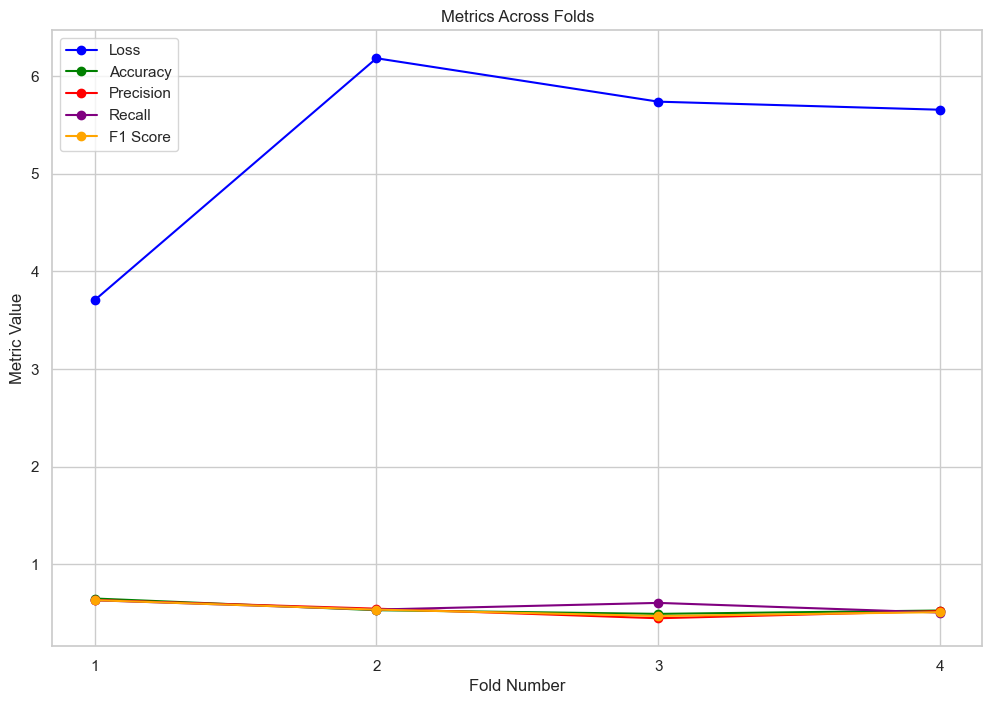

In [17]:
seed_1_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_1_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_1_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [18]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 867, Predictions: 867, Actuals: 867, Gender: 867


In [19]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [20]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.66 (73/110)


In [21]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [22]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, adult, senior, adult, adult, adult, se...",adult,adult,True
50,044A,"[kitten, adult, adult, kitten, kitten]",kitten,kitten,True
93,097B,"[senior, adult, adult, senior, adult, adult, a...",adult,adult,True
94,099A,"[adult, adult, senior, kitten, adult, adult, a...",adult,adult,True
1,001A,"[adult, adult, senior, senior, senior, senior,...",senior,senior,True
95,100A,[adult],adult,adult,True
53,048A,[kitten],kitten,kitten,True
52,047A,"[adult, senior, kitten, kitten, kitten, adult,...",kitten,kitten,True
51,045A,"[kitten, senior, kitten, kitten, kitten, kitte...",kitten,kitten,True
49,043A,"[kitten, kitten]",kitten,kitten,True


In [23]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']
# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()
# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')
# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Calculate the class statistics
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    accuracy=('Majority_Correct', lambda x: x.mean() * 100),
    total_count=('Majority_Correct', 'size')
).reset_index()

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group   accuracy  total_count
0            adult  78.688525           61
1           kitten  66.666667           15
2           senior  44.117647           34


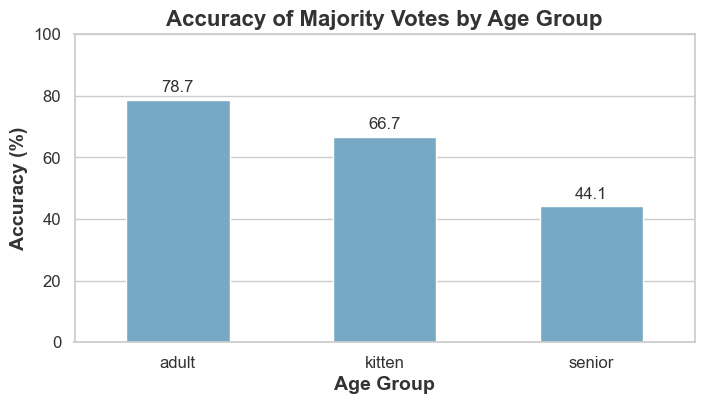

In [24]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [25]:
# For each fold
fold_class_stats = full_results.groupby('actual_age_group').agg(
    accuracy=('correct', lambda x: x.mean() * 100),
    total_count=('correct', 'size')
).reset_index()

# Store for final evaluation 
all_class_stats.append(fold_class_stats)

# Log the detailed stats
print("Detailed Class Statistics for this fold:")
print(fold_class_stats)

Detailed Class Statistics for this fold:
  actual_age_group   accuracy  total_count
0            adult  55.733945          436
1           kitten  57.657658          111
2           senior  51.562500          320


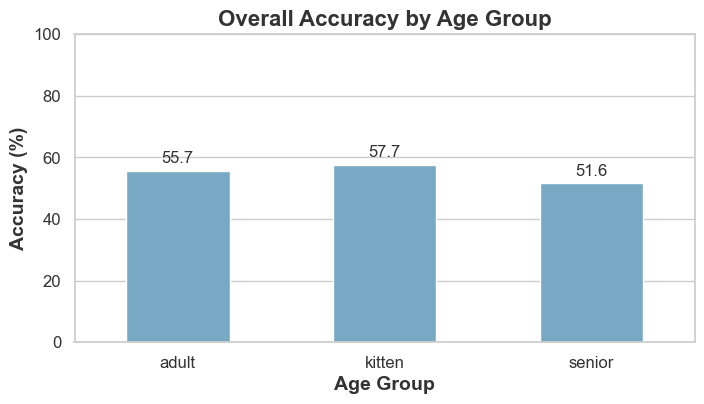

In [26]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(fold_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [27]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    218      127     58.26
1          M    359      183     50.97
2          X    290      162     55.86


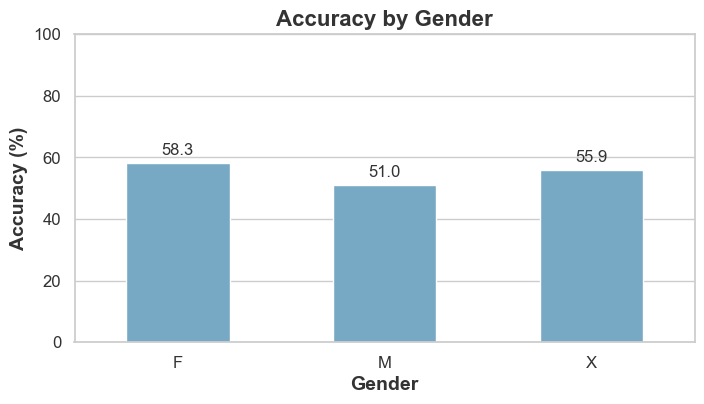

In [28]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [29]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.6636363636363637]
Total Class Statistics so far:
 [  actual_age_group   accuracy  total_count
0            adult  55.733945          436
1           kitten  57.657658          111
2           senior  51.562500          320]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    218      127     58.26
1          M    359      183     50.97
2          X    290      162     55.86]


# RANDOM SEED 2

In [30]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[1]))
np.random.seed(int(random_seeds[1]))
tf.random.set_seed(int(random_seeds[1]))

# Load datasets
dataframe = pd.read_csv('yamnet_looped_embeddings.csv')



def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 10),
    'senior': (10, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     472
senior    320
kitten    176
Name: age_group, dtype: int64


In [31]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [32]:
tf.keras.backend.clear_session()

## Run Setup

In [33]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[1]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )
    
    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.009272615392034748)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.40037235360372386))   
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping, accuracy_history], class_weight=weight_dict)
    
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
000A    39
002B    36
103A    33
047A    30
057A    28
074A    25
020A    23
055A    20
067A    20
059A    18
029A    17
019A    17
101A    16
106A    15
001A    15
028A    14
097B    14
111A    13
002A    13
039A    12
116A    12
016A    11
036A    11
025A    11
071A    10
015A    10
014B    10
040A    10
045A     9
022A     9
051B     9
072A     9
065A     9
095A     8
010A     8
031A     7
027A     7
053A     7
037A     6
023A     6
025C     6
008A     6
109A     6
070A     5
075A     5
012A     5
044A     5
062A     5
023B     5
009A     4
052A     4
003A     4
105A     4
104A     4
035A     4
006A     3
056A     3
058A     3
113A     3
011A     3
064A     3
060A     3
014A     3
093A     2
025B     2
066A     2
032A     2
018A     2
054A     2
102A     2
073A     1
091A     1
026B     1
004A     1
076A     1
090A     1
115A     1
041A     1
110A     1
024A     1
088A     1
019B     1
026C     1
092A     1
043A     1
100A     1
Name: cat_i

Epoch 1/1500
25/25 [==============================] - 0s 4ms/step - loss: 1.4484 - accuracy: 0.5520
Epoch 2/1500
25/25 [==============================] - 0s 3ms/step - loss: 0.5787 - accuracy: 0.7449
Epoch 3/1500
25/25 [==============================] - 0s 3ms/step - loss: 0.3559 - accuracy: 0.8376
Epoch 4/1500
25/25 [==============================] - 0s 3ms/step - loss: 0.3067 - accuracy: 0.8541
Epoch 5/1500
25/25 [==============================] - 0s 3ms/step - loss: 0.2294 - accuracy: 0.8909
Epoch 6/1500
25/25 [==============================] - 0s 4ms/step - loss: 0.2138 - accuracy: 0.9074
Epoch 7/1500
25/25 [==============================] - 0s 3ms/step - loss: 0.1729 - accuracy: 0.9251
Epoch 8/1500
25/25 [==============================] - 0s 3ms/step - loss: 0.1448 - accuracy: 0.9327
Epoch 9/1500
25/25 [==============================] - 0s 4ms/step - loss: 0.1288 - accuracy: 0.9505
Epoch 10/1500
25/25 [==============================] - 0s 3ms/step - loss: 0.1298 - accuracy: 0.9454

Majority Vote Accuracy for cat_id for this fold: 0.65 (17/26)
Before appending - Cat IDs: 0, Predictions: 0, Actuals: 0, Gender: 0
After appending - Cat IDs: 180, Predictions: 180, Actuals: 180, Gender: 180
Final Test Results - Loss: 6.822924613952637, Accuracy: 0.6000000238418579, Precision: 0.5852152023085897, Recall: 0.6298319327731093, F1 Score: 0.6019473081328751
Confusion Matrix:
 [[62 10 33]
 [ 6 18  0]
 [21  2 28]]
outer_fold 2
Train Set Group Distribution:
046A    66
000A    39
002B    36
103A    33
047A    30
057A    28
074A    25
020A    23
000B    20
059A    18
019A    17
101A    16
097A    16
106A    15
001A    15
042A    14
097B    14
028A    14
002A    13
051A    12
116A    12
039A    12
036A    11
068A    11
063A    11
016A    11
005A    11
040A    10
071A    10
022A     9
072A     9
033A     9
045A     9
094A     8
010A     8
013B     8
027A     7
053A     7
050A     7
099A     7
117A     7
008A     6
108A     6
023A     6
025C     6
037A     6
021A     6
007A     6
03

Moved to Training/Validation Set:
set()
Removed from Training/Validation Set:
set()
Moved to Test Set:
set()
Removed from Test Set
set()
AFTER SWAP - Unique Training/Validation Group IDs:
['000A' '000B' '002B' '003A' '004A' '005A' '007A' '010A' '012A' '013B'
 '014A' '014B' '015A' '016A' '018A' '019B' '021A' '022A' '023B' '025A'
 '025B' '026A' '026C' '029A' '031A' '033A' '034A' '035A' '036A' '037A'
 '038A' '040A' '041A' '042A' '043A' '044A' '045A' '046A' '048A' '049A'
 '050A' '051A' '051B' '052A' '053A' '055A' '056A' '058A' '060A' '061A'
 '063A' '065A' '066A' '067A' '068A' '069A' '072A' '073A' '075A' '076A'
 '087A' '088A' '091A' '094A' '095A' '096A' '097A' '097B' '099A' '100A'
 '102A' '103A' '104A' '106A' '108A' '109A' '110A' '111A' '113A' '115A'
 '116A' '117A']
AFTER SWAP - Unique Test Group IDs:
['001A' '002A' '006A' '008A' '009A' '011A' '019A' '020A' '023A' '024A'
 '025C' '026B' '027A' '028A' '032A' '039A' '047A' '054A' '057A' '059A'
 '062A' '064A' '070A' '071A' '074A' '090A' '092A' 

Majority Vote Accuracy for cat_id for this fold: 0.73 (22/30)
Before appending - Cat IDs: 362, Predictions: 362, Actuals: 362, Gender: 362
After appending - Cat IDs: 645, Predictions: 645, Actuals: 645, Gender: 645
Final Test Results - Loss: 4.859235763549805, Accuracy: 0.5759717226028442, Precision: 0.5078982984090271, Recall: 0.4795407185129616, F1 Score: 0.48604612576738004
Confusion Matrix:
 [[88 13 28]
 [15  6  9]
 [55  0 69]]
outer_fold 4
Train Set Group Distribution:
046A    66
047A    30
057A    28
074A    25
020A    23
055A    20
000B    20
067A    20
059A    18
029A    17
019A    17
097A    16
101A    16
001A    15
028A    14
042A    14
111A    13
002A    13
039A    12
051A    12
068A    11
005A    11
025A    11
063A    11
015A    10
014B    10
071A    10
065A     9
033A     9
051B     9
013B     8
095A     8
094A     8
031A     7
050A     7
099A     7
117A     7
027A     7
007A     6
023A     6
025C     6
108A     6
021A     6
109A     6
008A     6
012A     5
070A     5
034A

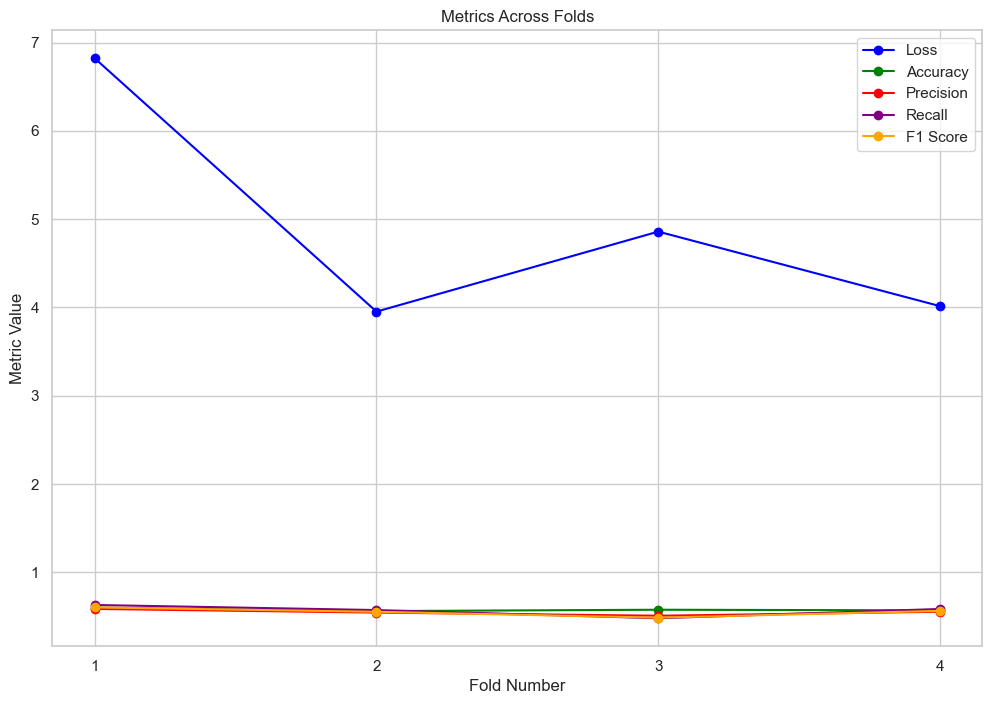

In [34]:
seed_2_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_2_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_2_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [35]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 870, Predictions: 870, Actuals: 870, Gender: 870


In [36]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [37]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.67 (74/110)


In [38]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [39]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, senior, senior, adult, adult, adult, a...",adult,adult,True
51,045A,"[kitten, senior, adult, kitten, kitten, adult,...",kitten,kitten,True
58,052A,"[adult, adult, adult, senior]",adult,adult,True
57,051B,"[senior, senior, adult, senior, adult, senior,...",senior,senior,True
93,097B,"[senior, adult, adult, senior, adult, adult, a...",adult,adult,True
1,001A,"[adult, adult, senior, senior, senior, senior,...",senior,senior,True
54,049A,[kitten],kitten,kitten,True
53,048A,[kitten],kitten,kitten,True
94,099A,"[adult, adult, senior, kitten, adult, adult, a...",adult,adult,True
50,044A,"[kitten, kitten, adult, kitten, adult]",kitten,kitten,True


In [40]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']
# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()
# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')
# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Calculate the class statistics
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    accuracy=('Majority_Correct', lambda x: x.mean() * 100),
    total_count=('Majority_Correct', 'size')
).reset_index()

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group   accuracy  total_count
0            adult  75.409836           61
1           kitten  66.666667           15
2           senior  52.941176           34


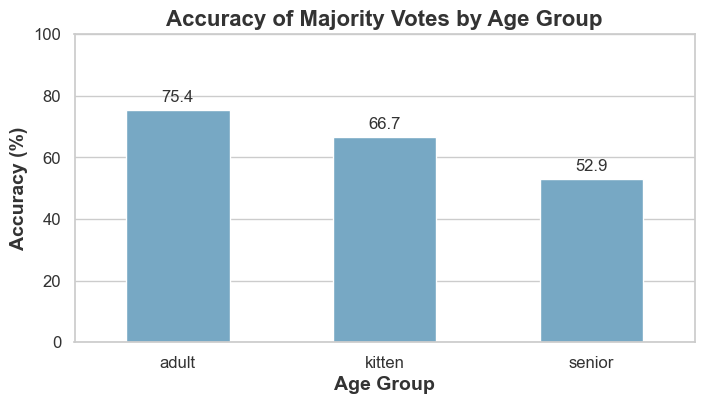

In [41]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [42]:
# For each fold
fold_class_stats = full_results.groupby('actual_age_group').agg(
    accuracy=('correct', lambda x: x.mean() * 100),
    total_count=('correct', 'size')
).reset_index()

# Store for final evaluation 
all_class_stats.append(fold_class_stats)

# Log the detailed stats
print("Detailed Class Statistics for this fold:")
print(fold_class_stats)

Detailed Class Statistics for this fold:
  actual_age_group   accuracy  total_count
0            adult  60.592255          439
1           kitten  53.153153          111
2           senior  55.000000          320


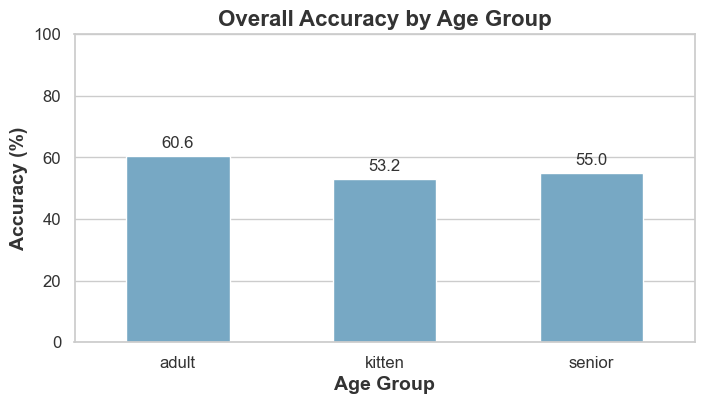

In [43]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(fold_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [44]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    218      138     63.30
1          M    362      210     58.01
2          X    290      153     52.76


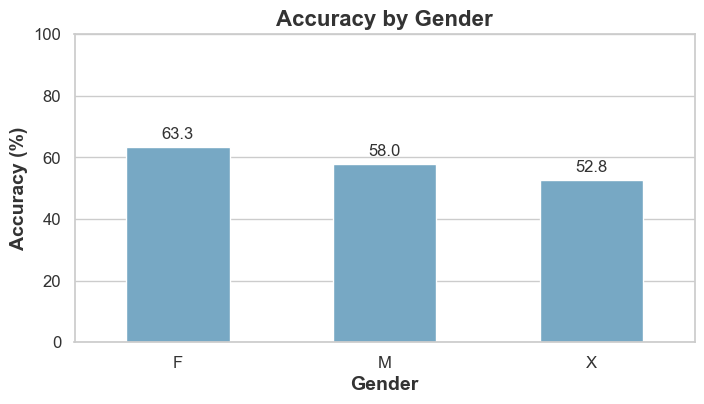

In [45]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [46]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.6636363636363637, 0.6727272727272727]
Total Class Statistics so far:
 [  actual_age_group   accuracy  total_count
0            adult  55.733945          436
1           kitten  57.657658          111
2           senior  51.562500          320,   actual_age_group   accuracy  total_count
0            adult  60.592255          439
1           kitten  53.153153          111
2           senior  55.000000          320]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    218      127     58.26
1          M    359      183     50.97
2          X    290      162     55.86,   all_gender  count  correct  accuracy
0          F    218      138     63.30
1          M    362      210     58.01
2          X    290      153     52.76]


# RANDOM SEED 3

In [47]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[2]))
np.random.seed(int(random_seeds[2]))
tf.random.set_seed(int(random_seeds[2]))

# Load datasets
dataframe = pd.read_csv('yamnet_looped_embeddings.csv')


def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 10),
    'senior': (10, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     472
senior    320
kitten    176
Name: age_group, dtype: int64


In [48]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [49]:
tf.keras.backend.clear_session()

## Run Setup

In [50]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[2]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )
    
    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.009272615392034748)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.40037235360372386))   
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping, accuracy_history], class_weight=weight_dict)
    
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
046A    66
000A    39
002B    36
047A    30
057A    28
074A    25
020A    23
067A    20
000B    20
055A    20
059A    18
029A    17
097A    16
101A    16
106A    15
001A    15
042A    14
028A    14
097B    14
002A    13
116A    12
025A    11
063A    11
005A    11
014B    10
040A    10
015A    10
033A     9
072A     9
051B     9
022A     9
095A     8
010A     8
094A     8
027A     7
053A     7
117A     7
050A     7
025C     6
023A     6
007A     6
108A     6
008A     6
070A     5
075A     5
062A     5
012A     5
034A     5
023B     5
044A     5
052A     4
035A     4
009A     4
026A     4
105A     4
014A     3
064A     3
056A     3
011A     3
058A     3
113A     3
006A     3
032A     2
054A     2
093A     2
102A     2
069A     2
018A     2
061A     2
087A     2
066A     2
038A     2
004A     1
041A     1
076A     1
115A     1
110A     1
073A     1
096A     1
048A     1
049A     1
024A     1
091A     1
026C     1
090A     1
026B     1
Name: cat_i

AFTER SWAP - Unique Training/Validation Group IDs:
['000A' '001A' '002B' '003A' '005A' '008A' '009A' '010A' '011A' '012A'
 '013B' '014A' '014B' '016A' '019A' '019B' '020A' '021A' '022A' '023A'
 '024A' '025B' '026A' '027A' '028A' '029A' '031A' '034A' '035A' '036A'
 '037A' '038A' '039A' '040A' '041A' '043A' '044A' '045A' '046A' '047A'
 '048A' '049A' '050A' '051A' '054A' '056A' '057A' '058A' '059A' '060A'
 '061A' '064A' '065A' '066A' '067A' '068A' '069A' '071A' '072A' '074A'
 '076A' '087A' '088A' '091A' '092A' '093A' '094A' '096A' '097B' '099A'
 '100A' '101A' '102A' '103A' '104A' '105A' '108A' '109A' '110A' '111A'
 '115A' '116A' '117A']
AFTER SWAP - Unique Test Group IDs:
['000B' '002A' '004A' '006A' '007A' '015A' '018A' '023B' '025A' '025C'
 '026B' '026C' '032A' '033A' '042A' '051B' '052A' '053A' '055A' '062A'
 '063A' '070A' '073A' '075A' '090A' '095A' '097A' '106A' '113A']
Length of X_train_val:
754
Length of y_train_val:
754
Length of groups_train_val:
754
No common groups found betwee

Unique Training/Validation Group IDs:
['000B' '001A' '002A' '003A' '004A' '005A' '006A' '007A' '009A' '013B'
 '015A' '016A' '018A' '019A' '019B' '021A' '023B' '024A' '025A' '025B'
 '025C' '026A' '026B' '026C' '027A' '028A' '029A' '031A' '032A' '033A'
 '036A' '037A' '038A' '039A' '042A' '043A' '044A' '045A' '046A' '049A'
 '051A' '051B' '052A' '053A' '055A' '057A' '059A' '060A' '061A' '062A'
 '063A' '065A' '068A' '070A' '071A' '072A' '073A' '075A' '076A' '087A'
 '088A' '090A' '092A' '093A' '094A' '095A' '096A' '097A' '097B' '099A'
 '100A' '102A' '103A' '104A' '105A' '106A' '109A' '110A' '111A' '113A'
 '115A' '117A']
Unique Test Group IDs:
['000A' '002B' '008A' '010A' '011A' '012A' '014A' '014B' '020A' '022A'
 '023A' '034A' '035A' '040A' '041A' '047A' '048A' '050A' '054A' '056A'
 '058A' '064A' '066A' '067A' '069A' '074A' '091A' '101A' '108A' '116A']
No common groups found between train and test sets.
Moved to Training/Validation Set:
{'000A'}
Removed from Training/Validation Set:
{'073A'}

Majority Vote Accuracy for cat_id for this fold: 0.67 (20/30)
Before appending - Cat IDs: 420, Predictions: 420, Actuals: 420, Gender: 420
After appending - Cat IDs: 683, Predictions: 683, Actuals: 683, Gender: 683
Final Test Results - Loss: 3.6855623722076416, Accuracy: 0.5209125280380249, Precision: 0.4840795262910977, Recall: 0.509503877032869, F1 Score: 0.4809761796585968
Confusion Matrix:
 [[84 27 41]
 [25 19 15]
 [18  0 34]]
outer_fold 4
Train Set Group Distribution:
000A    39
002B    36
103A    33
047A    30
074A    25
020A    23
000B    20
067A    20
055A    20
019A    17
097A    16
101A    16
106A    15
042A    14
111A    13
002A    13
116A    12
039A    12
051A    12
068A    11
036A    11
063A    11
025A    11
016A    11
040A    10
014B    10
015A    10
071A    10
051B     9
045A     9
065A     9
033A     9
022A     9
013B     8
095A     8
010A     8
099A     7
050A     7
031A     7
053A     7
108A     6
109A     6
037A     6
008A     6
007A     6
021A     6
023A     6
025C 

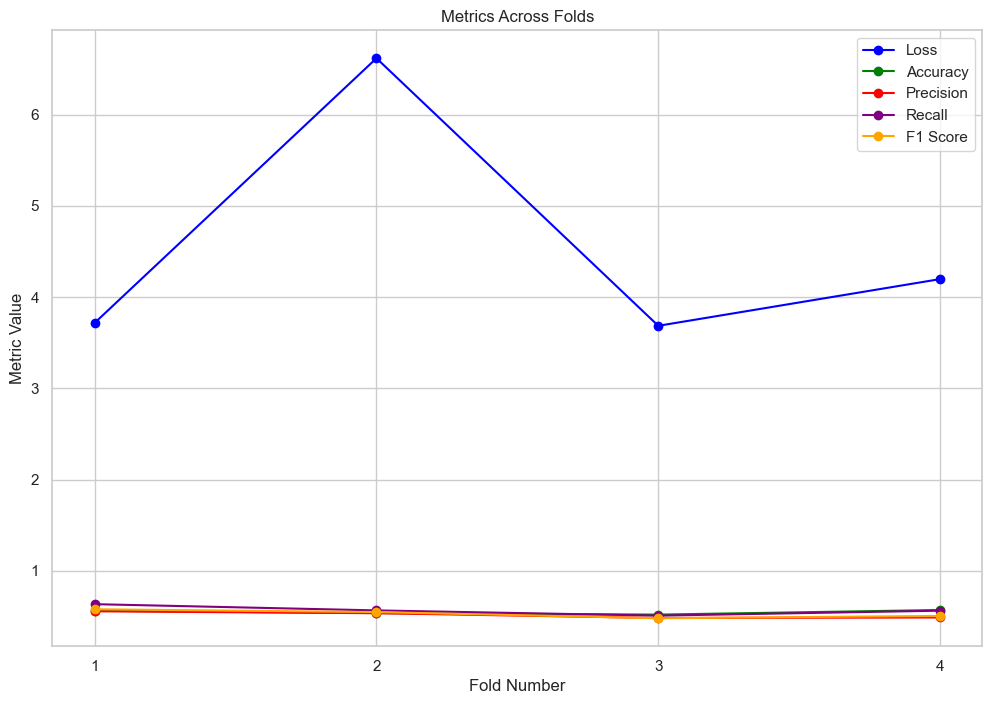

In [51]:
seed_3_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_3_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_3_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [52]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 865, Predictions: 865, Actuals: 865, Gender: 865


In [53]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [54]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.70 (77/110)


In [55]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [56]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, senior, adult, adult, adult, adult, se...",adult,adult,True
78,072A,"[adult, kitten, senior, adult, adult, kitten, ...",adult,adult,True
76,070A,"[adult, senior, senior, adult, adult]",adult,adult,True
75,069A,"[senior, adult]",adult,adult,True
74,068A,"[senior, adult, senior, adult, senior, senior,...",adult,adult,True
73,067A,"[adult, kitten, kitten, kitten, kitten, adult,...",adult,adult,True
71,065A,"[adult, senior, adult, kitten, adult, adult, k...",adult,adult,True
70,064A,"[adult, kitten, senior]",adult,adult,True
68,062A,"[adult, adult, adult, senior, adult]",adult,adult,True
65,059A,"[senior, senior, senior, senior, senior, senio...",senior,senior,True


In [57]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']
# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()
# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')
# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Calculate the class statistics
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    accuracy=('Majority_Correct', lambda x: x.mean() * 100),
    total_count=('Majority_Correct', 'size')
).reset_index()

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group   accuracy  total_count
0            adult  80.327869           61
1           kitten  73.333333           15
2           senior  50.000000           34


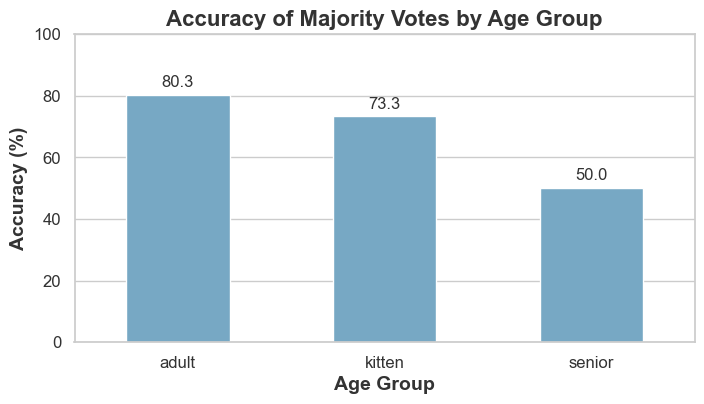

In [58]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [59]:
# For each fold
fold_class_stats = full_results.groupby('actual_age_group').agg(
    accuracy=('correct', lambda x: x.mean() * 100),
    total_count=('correct', 'size')
).reset_index()

# Store for final evaluation 
all_class_stats.append(fold_class_stats)

# Log the detailed stats
print("Detailed Class Statistics for this fold:")
print(fold_class_stats)

Detailed Class Statistics for this fold:
  actual_age_group   accuracy  total_count
0            adult  56.221198          434
1           kitten  54.054054          111
2           senior  52.500000          320


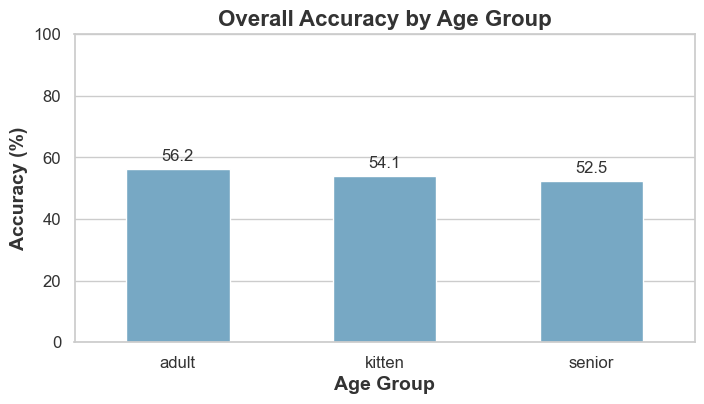

In [60]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(fold_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [61]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    218      126     57.80
1          M    356      181     50.84
2          X    291      165     56.70


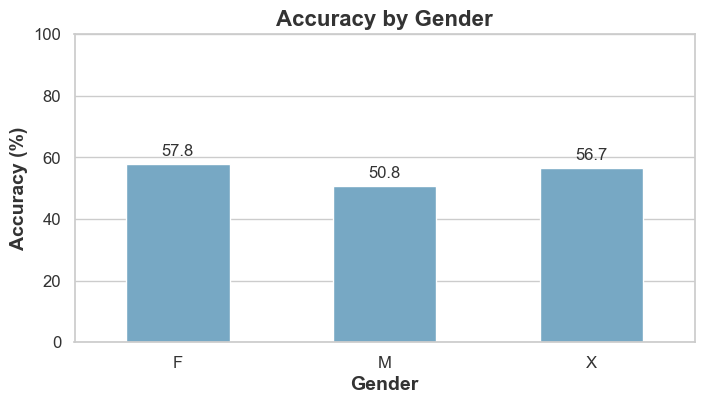

In [62]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [63]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.6636363636363637, 0.6727272727272727, 0.7]
Total Class Statistics so far:
 [  actual_age_group   accuracy  total_count
0            adult  55.733945          436
1           kitten  57.657658          111
2           senior  51.562500          320,   actual_age_group   accuracy  total_count
0            adult  60.592255          439
1           kitten  53.153153          111
2           senior  55.000000          320,   actual_age_group   accuracy  total_count
0            adult  56.221198          434
1           kitten  54.054054          111
2           senior  52.500000          320]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    218      127     58.26
1          M    359      183     50.97
2          X    290      162     55.86,   all_gender  count  correct  accuracy
0          F    218      138     63.30
1          M    362      210     58.01
2          X    290      153     52.76,   all_gender  count

# RANDOM SEED 4

In [64]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[3])) 
np.random.seed(int(random_seeds[3]))
tf.random.set_seed(int(random_seeds[3]))

# Load datasets
dataframe = pd.read_csv('yamnet_looped_embeddings.csv')


def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 10),
    'senior': (10, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     472
senior    320
kitten    176
Name: age_group, dtype: int64


In [65]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [66]:
tf.keras.backend.clear_session()

## Run Setup

In [67]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[3]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )
    
    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.009272615392034748)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.40037235360372386))   
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping, accuracy_history], class_weight=weight_dict)
    
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
000A    39
002B    36
103A    33
047A    30
074A    25
020A    23
067A    20
059A    18
029A    17
019A    17
101A    16
106A    15
097B    14
028A    14
002A    13
111A    13
051A    12
039A    12
116A    12
016A    11
025A    11
005A    11
063A    11
068A    11
071A    10
015A    10
040A    10
014B    10
072A     9
045A     9
065A     9
022A     9
033A     9
051B     9
010A     8
099A     7
053A     7
027A     7
108A     6
021A     6
109A     6
008A     6
037A     6
007A     6
025C     6
023B     5
062A     5
070A     5
012A     5
075A     5
104A     4
052A     4
003A     4
035A     4
009A     4
026A     4
105A     4
060A     3
064A     3
056A     3
058A     3
006A     3
113A     3
054A     2
102A     2
087A     2
093A     2
066A     2
069A     2
032A     2
018A     2
048A     1
026B     1
004A     1
076A     1
041A     1
019B     1
026C     1
091A     1
024A     1
110A     1
073A     1
049A     1
096A     1
043A     1
100A     1
Name: cat_i


 Starting training on unseen test set

Age group distribution: Counter({0: 301, 2: 282, 1: 168})
Epoch 1/1500
24/24 [==============================] - 0s 3ms/step - loss: 1.3913 - accuracy: 0.6019
Epoch 2/1500
24/24 [==============================] - 0s 3ms/step - loss: 0.4861 - accuracy: 0.7909
Epoch 3/1500
24/24 [==============================] - 0s 3ms/step - loss: 0.3153 - accuracy: 0.8735
Epoch 4/1500
24/24 [==============================] - 0s 3ms/step - loss: 0.3001 - accuracy: 0.8682
Epoch 5/1500
24/24 [==============================] - 0s 3ms/step - loss: 0.2038 - accuracy: 0.9161
Epoch 6/1500
24/24 [==============================] - 0s 3ms/step - loss: 0.1766 - accuracy: 0.9308
Epoch 7/1500
24/24 [==============================] - 0s 3ms/step - loss: 0.1235 - accuracy: 0.9587
Epoch 8/1500
24/24 [==============================] - 0s 4ms/step - loss: 0.1366 - accuracy: 0.9521
Epoch 9/1500
24/24 [==============================] - 0s 3ms/step - loss: 0.1371 - accuracy: 0.9481
Ep

AFTER SWAP - Unique Training/Validation Group IDs:
['000A' '000B' '001A' '003A' '005A' '007A' '008A' '009A' '010A' '011A'
 '013B' '014A' '014B' '016A' '019A' '020A' '021A' '022A' '023A' '023B'
 '025A' '025B' '025C' '026B' '028A' '031A' '032A' '033A' '034A' '036A'
 '038A' '039A' '041A' '042A' '044A' '046A' '047A' '048A' '049A' '050A'
 '051A' '052A' '053A' '055A' '056A' '057A' '061A' '062A' '063A' '065A'
 '066A' '067A' '068A' '069A' '070A' '071A' '072A' '073A' '074A' '076A'
 '088A' '090A' '092A' '093A' '094A' '095A' '096A' '097A' '097B' '099A'
 '100A' '102A' '104A' '108A' '109A' '110A' '111A' '113A' '115A' '116A'
 '117A']
AFTER SWAP - Unique Test Group IDs:
['002A' '002B' '004A' '006A' '012A' '015A' '018A' '019B' '024A' '026A'
 '026C' '027A' '029A' '035A' '037A' '040A' '043A' '045A' '051B' '054A'
 '058A' '059A' '060A' '064A' '075A' '087A' '091A' '101A' '103A' '105A'
 '106A']
Length of X_train_val:
723
Length of y_train_val:
723
Length of groups_train_val:
723
No common groups found betwe

Unique Cat IDs per Age Group in Training/Validation Set:
age_group
adult     [002A, 033A, 000B, 071A, 000A, 026A, 065A, 023...
kitten    [046A, 042A, 109A, 040A, 049A, 045A, 044A, 043...
senior    [117A, 015A, 106A, 057A, 001A, 090A, 051B, 091...
Name: cat_id, dtype: object
Unique Cat IDs per Age Group in Testing Set:
age_group
adult     [070A, 020A, 021A, 072A, 022A, 063A, 069A, 032...
kitten                       [014B, 110A, 047A, 048A, 111A]
senior           [028A, 053A, 113A, 116A, 051A, 025A, 039A]
Name: cat_id, dtype: object
Count of Unique Cat IDs per Age Group in Training/Validation Set:
{'adult': 48, 'kitten': 11, 'senior': 27}
Count of Unique Cat IDs per Age Group in Testing Set:
{'adult': 14, 'kitten': 5, 'senior': 7}
Unique Training/Validation Group IDs:
['000A' '000B' '001A' '002A' '002B' '004A' '005A' '006A' '007A' '008A'
 '009A' '010A' '011A' '012A' '013B' '014A' '015A' '016A' '018A' '019A'
 '019B' '023A' '023B' '024A' '025B' '025C' '026A' '026C' '027A' '029A'
 '031A' '

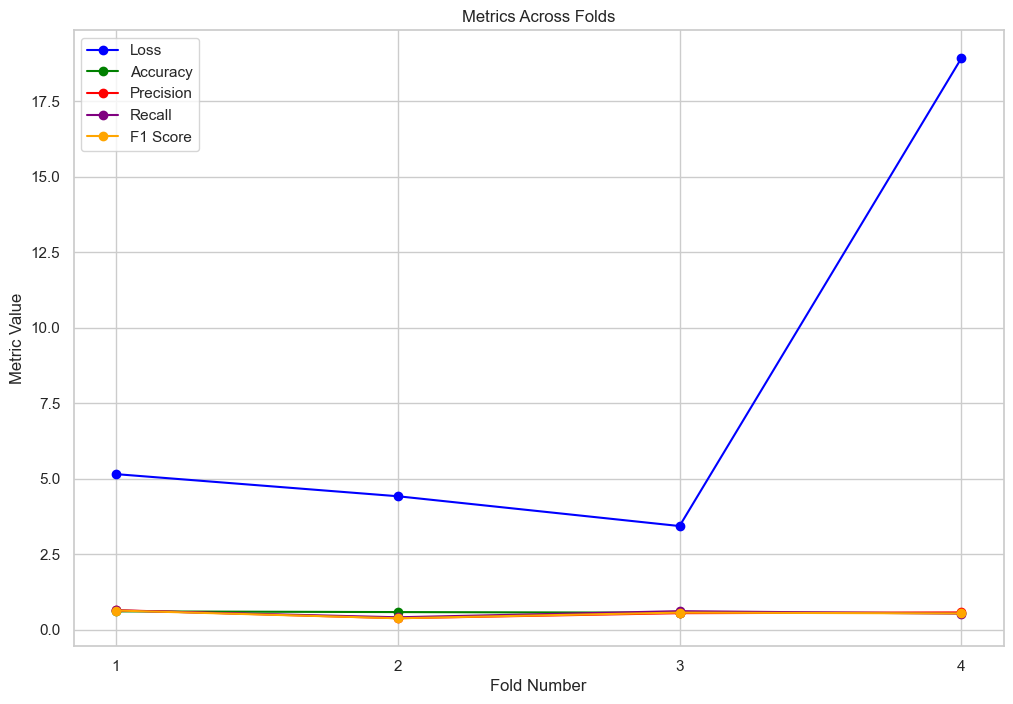

In [68]:
seed_4_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_4_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_4_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [69]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 872, Predictions: 872, Actuals: 872, Gender: 872


In [70]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [71]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.68 (75/110)


In [72]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [73]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, adult, senior, adult, adult, adult, ad...",adult,adult,True
62,056A,"[adult, senior, senior]",senior,senior,True
76,070A,"[adult, senior, senior, adult, adult]",adult,adult,True
74,068A,"[senior, adult, adult, adult, senior, senior, ...",adult,adult,True
73,067A,"[adult, adult, kitten, adult, adult, adult, ad...",adult,adult,True
70,064A,"[kitten, adult, adult]",adult,adult,True
69,063A,"[kitten, adult, kitten, kitten, adult, adult, ...",adult,adult,True
68,062A,"[adult, adult, adult, senior, adult]",adult,adult,True
65,059A,"[senior, senior, senior, senior, senior, senio...",senior,senior,True
63,057A,"[adult, senior, senior, senior, adult, senior,...",senior,senior,True


In [74]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']
# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()
# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')
# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Calculate the class statistics
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    accuracy=('Majority_Correct', lambda x: x.mean() * 100),
    total_count=('Majority_Correct', 'size')
).reset_index()

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group   accuracy  total_count
0            adult  78.688525           61
1           kitten  66.666667           15
2           senior  50.000000           34


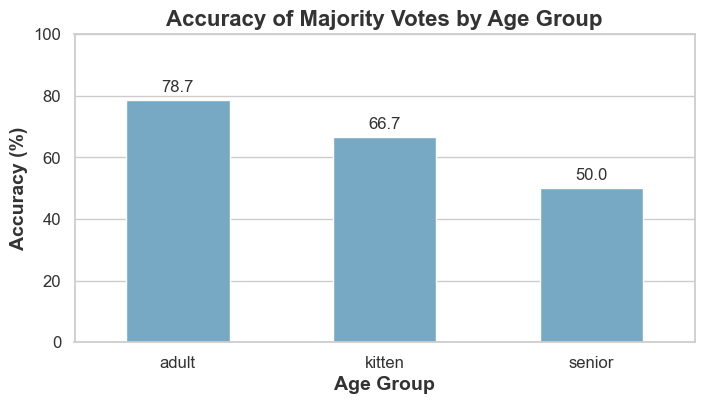

In [75]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [76]:
# For each fold
fold_class_stats = full_results.groupby('actual_age_group').agg(
    accuracy=('correct', lambda x: x.mean() * 100),
    total_count=('correct', 'size')
).reset_index()

# Store for final evaluation 
all_class_stats.append(fold_class_stats)

# Log the detailed stats
print("Detailed Class Statistics for this fold:")
print(fold_class_stats)

Detailed Class Statistics for this fold:
  actual_age_group   accuracy  total_count
0            adult  61.904762          441
1           kitten  49.549550          111
2           senior  53.437500          320


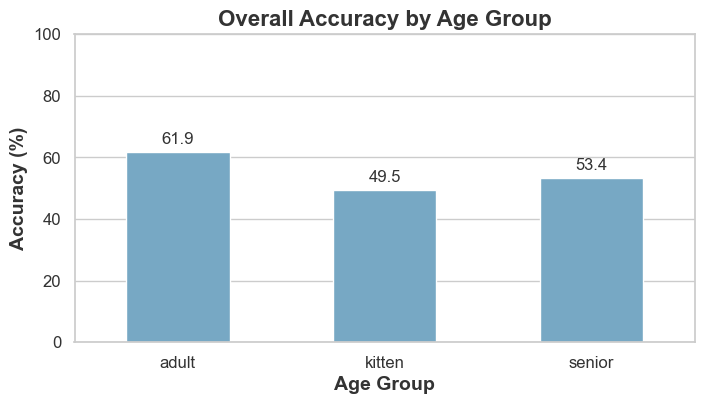

In [77]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(fold_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [78]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    218      133     61.01
1          M    364      210     57.69
2          X    290      156     53.79


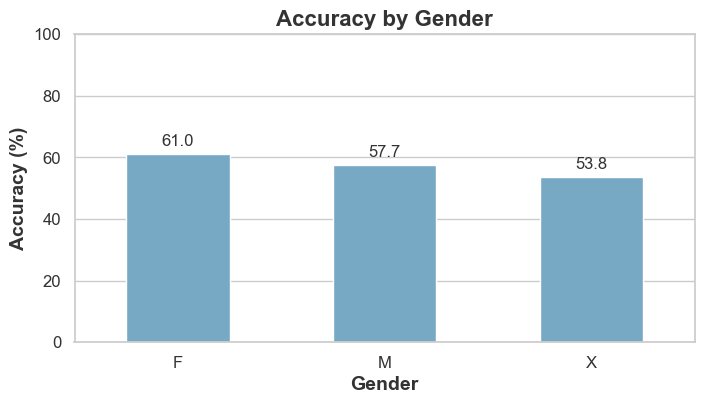

In [79]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [80]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.6636363636363637, 0.6727272727272727, 0.7, 0.6818181818181818]
Total Class Statistics so far:
 [  actual_age_group   accuracy  total_count
0            adult  55.733945          436
1           kitten  57.657658          111
2           senior  51.562500          320,   actual_age_group   accuracy  total_count
0            adult  60.592255          439
1           kitten  53.153153          111
2           senior  55.000000          320,   actual_age_group   accuracy  total_count
0            adult  56.221198          434
1           kitten  54.054054          111
2           senior  52.500000          320,   actual_age_group   accuracy  total_count
0            adult  61.904762          441
1           kitten  49.549550          111
2           senior  53.437500          320]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    218      127     58.26
1          M    359      183     50.97
2          X    290    

# RANDOM SEED 5

In [81]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[4]))
np.random.seed(int(random_seeds[4]))
tf.random.set_seed(int(random_seeds[4]))

# Load datasets
dataframe = pd.read_csv('yamnet_looped_embeddings.csv')


def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 10),
    'senior': (10, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     472
senior    320
kitten    176
Name: age_group, dtype: int64


In [82]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [83]:
tf.keras.backend.clear_session()

## Run Setup

In [84]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[4]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )
    
    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adamax': Adamax(learning_rate=0.009272615392034748)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(480, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.40037235360372386))   
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adamax']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping, accuracy_history], class_weight=weight_dict)
    
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)

outer_fold 1
Train Set Group Distribution:
046A    66
000A    39
002B    36
103A    33
057A    28
074A    25
020A    23
055A    20
000B    20
029A    17
019A    17
097A    16
101A    16
001A    15
028A    14
042A    14
111A    13
039A    12
051A    12
116A    12
005A    11
016A    11
025A    11
063A    11
068A    11
014B    10
071A    10
065A     9
045A     9
022A     9
033A     9
051B     9
095A     8
094A     8
013B     8
010A     8
099A     7
050A     7
117A     7
027A     7
008A     6
007A     6
023A     6
108A     6
025C     6
109A     6
070A     5
044A     5
075A     5
012A     5
023B     5
034A     5
104A     4
105A     4
009A     4
026A     4
052A     4
011A     3
014A     3
060A     3
056A     3
113A     3
058A     3
006A     3
025B     2
018A     2
032A     2
054A     2
087A     2
066A     2
093A     2
038A     2
069A     2
019B     1
026B     1
041A     1
026C     1
092A     1
073A     1
088A     1
096A     1
043A     1
024A     1
091A     1
090A     1
100A     1
Name: cat_i

Unique Training/Validation Group IDs:
['000B' '002A' '002B' '003A' '004A' '005A' '006A' '007A' '008A' '009A'
 '012A' '014A' '014B' '015A' '018A' '019A' '020A' '021A' '022A' '023A'
 '025A' '025C' '026A' '026B' '026C' '027A' '029A' '031A' '032A' '035A'
 '036A' '037A' '038A' '039A' '040A' '042A' '043A' '045A' '046A' '047A'
 '048A' '049A' '051B' '052A' '053A' '054A' '055A' '056A' '057A' '058A'
 '059A' '060A' '061A' '062A' '063A' '064A' '067A' '068A' '070A' '071A'
 '072A' '073A' '076A' '087A' '088A' '090A' '091A' '094A' '095A' '097A'
 '097B' '100A' '101A' '102A' '103A' '104A' '106A' '108A' '109A' '110A'
 '111A' '115A' '117A']
Unique Test Group IDs:
['000A' '001A' '010A' '011A' '013B' '016A' '019B' '023B' '024A' '025B'
 '028A' '033A' '034A' '041A' '044A' '050A' '051A' '065A' '066A' '069A'
 '074A' '075A' '092A' '093A' '096A' '099A' '105A' '113A' '116A']
No common groups found between train and test sets.
Moved to Training/Validation Set:
{'000A'}
Removed from Training/Validation Set:
{'021A'}

Epoch 1/1500
23/23 [==============================] - 0s 3ms/step - loss: 1.5508 - accuracy: 0.5674
Epoch 2/1500
23/23 [==============================] - 0s 3ms/step - loss: 0.5152 - accuracy: 0.7809
Epoch 3/1500
23/23 [==============================] - 0s 3ms/step - loss: 0.3785 - accuracy: 0.8287
Epoch 4/1500
23/23 [==============================] - 0s 3ms/step - loss: 0.2704 - accuracy: 0.8933
Epoch 5/1500
23/23 [==============================] - 0s 2ms/step - loss: 0.2298 - accuracy: 0.9185
Epoch 6/1500
23/23 [==============================] - 0s 3ms/step - loss: 0.1842 - accuracy: 0.9228
Epoch 7/1500
23/23 [==============================] - 0s 2ms/step - loss: 0.1333 - accuracy: 0.9508
Epoch 8/1500
23/23 [==============================] - 0s 2ms/step - loss: 0.1607 - accuracy: 0.9312
Epoch 9/1500
23/23 [==============================] - 0s 2ms/step - loss: 0.1461 - accuracy: 0.9424
Epoch 10/1500
23/23 [==============================] - 0s 2ms/step - loss: 0.1322 - accuracy: 0.9508

Moved to Training/Validation Set:
{'046A'}
Removed from Training/Validation Set:
{'049A'}
Moved to Test Set:
{'049A'}
Removed from Test Set
{'046A'}
AFTER SWAP - Unique Training/Validation Group IDs:
['000A' '001A' '002A' '002B' '003A' '004A' '005A' '006A' '007A' '009A'
 '010A' '011A' '013B' '014A' '015A' '016A' '019A' '019B' '020A' '021A'
 '022A' '023A' '023B' '024A' '025A' '025B' '026A' '026B' '028A' '029A'
 '031A' '033A' '034A' '035A' '036A' '037A' '040A' '041A' '043A' '044A'
 '045A' '046A' '047A' '048A' '050A' '051A' '051B' '052A' '053A' '054A'
 '056A' '057A' '058A' '059A' '061A' '062A' '063A' '064A' '065A' '066A'
 '067A' '069A' '071A' '072A' '073A' '074A' '075A' '076A' '088A' '090A'
 '091A' '092A' '093A' '094A' '096A' '097B' '099A' '102A' '105A' '106A'
 '110A' '111A' '113A' '115A' '116A']
AFTER SWAP - Unique Test Group IDs:
['000B' '008A' '012A' '014B' '018A' '025C' '026C' '027A' '032A' '038A'
 '039A' '042A' '049A' '055A' '060A' '068A' '070A' '087A' '095A' '097A'
 '100A' '101A' '1

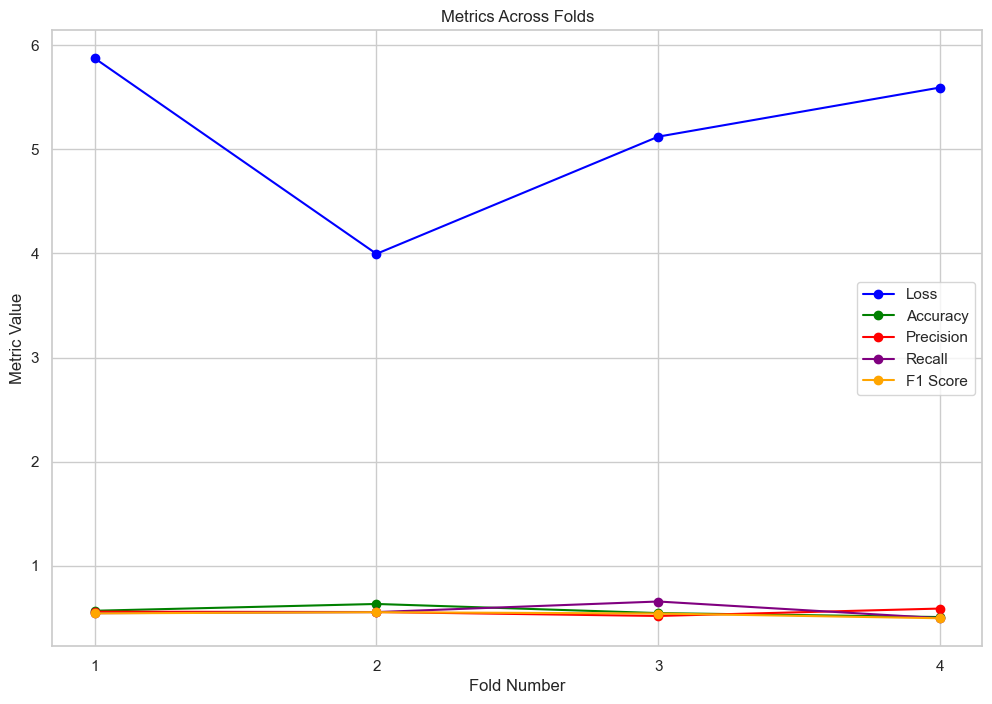

In [85]:
seed_5_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_5_training_acc_values = cv_training_acc_total

# Plotting all fold metrics|
seed_5_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [86]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 870, Predictions: 870, Actuals: 870, Gender: 870


In [87]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [88]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.73 (80/110)


In [89]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [90]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, adult, senior, adult, adult, adult, se...",adult,adult,True
78,072A,"[adult, adult, senior, senior, adult, adult, a...",adult,adult,True
75,069A,"[adult, adult]",adult,adult,True
73,067A,"[senior, adult, kitten, adult, adult, adult, a...",adult,adult,True
71,065A,"[adult, senior, adult, kitten, adult, adult, k...",adult,adult,True
70,064A,"[kitten, adult, senior]",adult,adult,True
69,063A,"[kitten, kitten, kitten, adult, adult, adult, ...",adult,adult,True
68,062A,"[kitten, adult, adult, adult, adult]",adult,adult,True
66,060A,"[senior, adult, senior]",senior,senior,True
65,059A,"[senior, senior, senior, senior, senior, senio...",senior,senior,True


In [91]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']
# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()
# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')
# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Calculate the class statistics
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    accuracy=('Majority_Correct', lambda x: x.mean() * 100),
    total_count=('Majority_Correct', 'size')
).reset_index()

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group   accuracy  total_count
0            adult  83.606557           61
1           kitten  60.000000           15
2           senior  58.823529           34


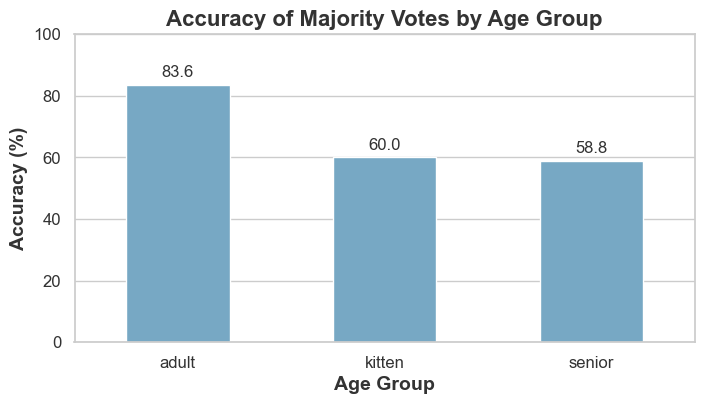

In [92]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


In [93]:
full_results

,cat_id,predicted_age_group,actual_age_group,all_gender,correct
0,002A,adult,adult,F,True
1,015A,adult,senior,M,False
2,106A,adult,senior,M,False
3,053A,senior,senior,F,True
4,053A,senior,senior,F,True
...,...,...,...,...,...
865,039A,senior,senior,X,True
866,025C,adult,senior,M,False
867,025C,adult,senior,M,False
868,025C,adult,senior,M,False


## Detailed Class Statistics

In [94]:
# For each fold
fold_class_stats = full_results.groupby('actual_age_group').agg(
    accuracy=('correct', lambda x: x.mean() * 100),
    total_count=('correct', 'size')
).reset_index()

# Store for final evaluation 
all_class_stats.append(fold_class_stats)

# Log the detailed stats
print("Detailed Class Statistics for this fold:")
print(fold_class_stats)

Detailed Class Statistics for this fold:
  actual_age_group   accuracy  total_count
0            adult  59.681093          439
1           kitten  49.549550          111
2           senior  53.437500          320


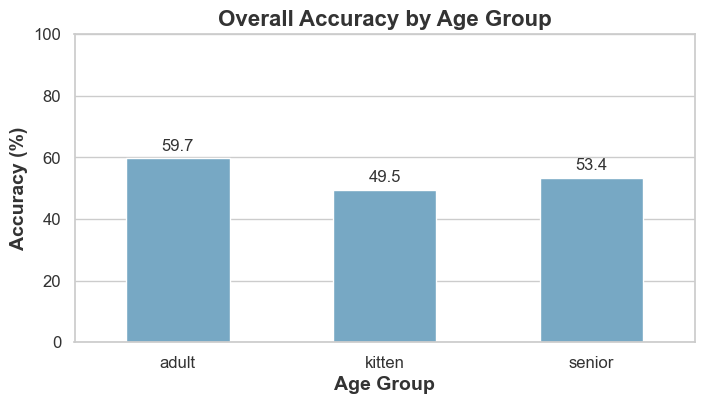

In [95]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(fold_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [96]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    218      139     63.76
1          M    362      201     55.52
2          X    290      148     51.03


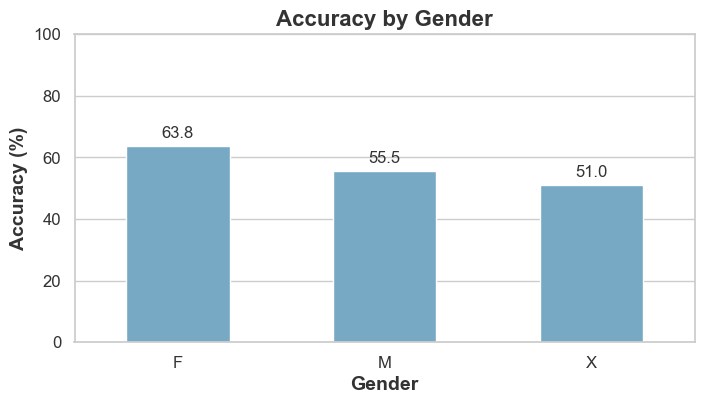

In [97]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [98]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats) 
print("Total Majority Vote Statistics so far:\n", all_majority_vote_details) 
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.6636363636363637, 0.6727272727272727, 0.7, 0.6818181818181818, 0.7272727272727273]
Total Class Statistics so far:
 [  actual_age_group   accuracy  total_count
0            adult  55.733945          436
1           kitten  57.657658          111
2           senior  51.562500          320,   actual_age_group   accuracy  total_count
0            adult  60.592255          439
1           kitten  53.153153          111
2           senior  55.000000          320,   actual_age_group   accuracy  total_count
0            adult  56.221198          434
1           kitten  54.054054          111
2           senior  52.500000          320,   actual_age_group   accuracy  total_count
0            adult  61.904762          441
1           kitten  49.549550          111
2           senior  53.437500          320,   actual_age_group   accuracy  total_count
0            adult  59.681093          439
1           kitten  49.549550          111
2           senior  53.

# --------------

# Total Final Results & Analysis

In [99]:
# Count unique cat_id per age group 
unique_cats_per_age_group = dataframe.groupby('age_group')['cat_id'].nunique()

# Display the counts
print("Unique cat_id counts in original dataframe:", unique_cats_per_age_group)

Unique cat_id counts in original dataframe: age_group
adult     62
kitten    16
senior    34
Name: cat_id, dtype: int64


## Metrics

In [100]:
# Calculate overall metrics
overall_avg_loss = np.mean(all_losses)
overall_avg_acc = np.mean(all_accuracies)
overall_avg_precision = np.mean(all_precisions)
overall_avg_recall = np.mean(all_recalls)
overall_avg_f1 = np.mean(all_f1)

print("Overall Average Metrics:")
print("Loss:", overall_avg_loss)
print("Accuracy:", overall_avg_acc)
print("Precision:", overall_avg_precision)
print("Recall:", overall_avg_recall)
print("F1 Score:", overall_avg_f1)

Overall Average Metrics:
Loss: 5.583205366134644
Accuracy: 0.5628187879920006
Precision: 0.5387259916530425
Recall: 0.5634558003842738
F1 Score: 0.5361591722608988


## Majority Votes

In [101]:
# After calculating class_stats for each fold
all_majority_vote_details.append(class_stats)

# At the end, when calculating the final metrics:
total_majority_vote_details = pd.concat(all_majority_vote_details)

macro_avg_majority_vote_accuracy = (
    total_majority_vote_details.groupby('actual_age_group')['accuracy'].mean().mean()
)

print(f"Macro-Averaged Majority Vote Accuracy: {macro_avg_majority_vote_accuracy}")

# For class-wise accuracies:
macro_avg_class_accuracies = total_majority_vote_details.groupby('actual_age_group')['accuracy'].mean()

print("Macro-Averaged Class Accuracies:")
print(macro_avg_class_accuracies)

macro_avg_class_accuracies_df = macro_avg_class_accuracies.reset_index()
macro_avg_class_accuracies_df.columns = ['actual_age_group', 'accuracy']

Macro-Averaged Majority Vote Accuracy: 66.0203935854852
Macro-Averaged Class Accuracies:
actual_age_group
adult     80.054645
kitten    65.555556
senior    52.450980
Name: accuracy, dtype: float64


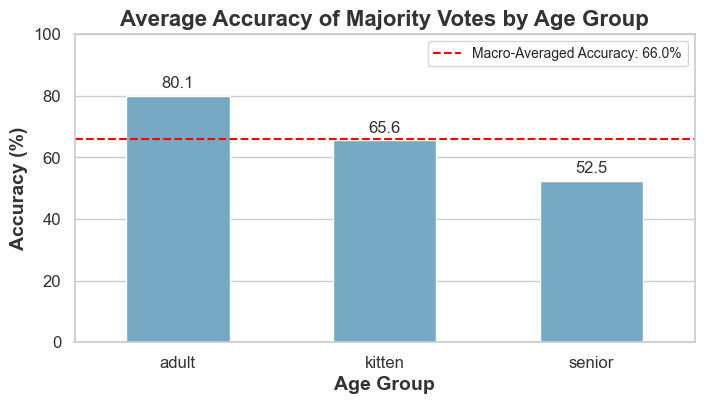

In [102]:
# Use the modified function
styled_barplot_with_average(macro_avg_class_accuracies_df, 'actual_age_group', 'accuracy', 
                            'Average Accuracy of Majority Votes by Age Group', 
                            'Age Group', 'Accuracy (%)', 
                            average_line=macro_avg_majority_vote_accuracy)

## Detailed Class Statistics

In [103]:
# Calculate the average class statistics across all folds and seeds
average_class_stats = pd.concat(all_class_stats).groupby('actual_age_group').agg({
    'accuracy': 'mean',
    'total_count': 'mean'
}).reset_index()
print("Average Class Statistics across all folds and seeds:")
print(average_class_stats)

# Calculate macro-averaged accuracy
macro_accuracy = average_class_stats['accuracy'].mean()
print(f"Macro-Averaged Accuracy: {macro_accuracy:.2f}%")

# Calculate macro-averaged accuracy for detailed class statistics
macro_avg_class_accuracy = average_class_stats['accuracy'].mean()

Average Class Statistics across all folds and seeds:
  actual_age_group   accuracy  total_count
0            adult  58.826651        437.8
1           kitten  52.792793        111.0
2           senior  53.187500        320.0
Macro-Averaged Accuracy: 54.94%


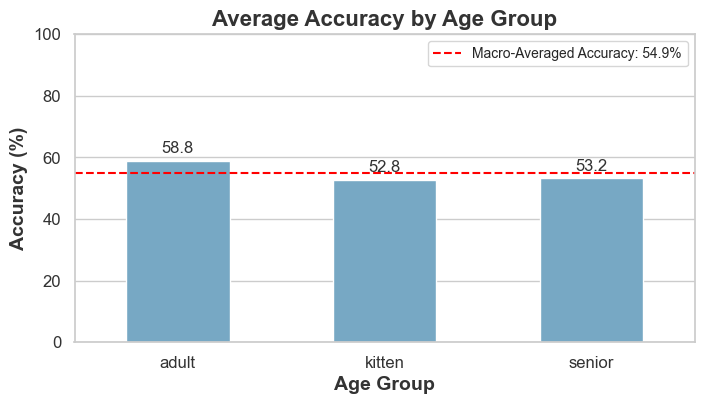

In [104]:
# Use the modified function for detailed class statistics
styled_barplot_with_average(average_class_stats, 'actual_age_group', 'accuracy', 
                            'Average Accuracy by Age Group', 
                            'Age Group', 'Accuracy (%)', 
                            average_line=macro_avg_class_accuracy)

In [105]:
# Concatenate all gender stats DataFrames and calculate the mean of accuracies
total_gender_stats = pd.concat(all_gender_stats)
average_gender_stats = total_gender_stats.groupby('all_gender').agg({
    'count': 'sum',  
    'correct': 'sum'  
}).reset_index()
average_gender_stats['accuracy'] = (average_gender_stats['correct'] / average_gender_stats['count']) * 100

print("Average Gender Accuracy:")
print(average_gender_stats)

Average Gender Accuracy:
  all_gender  count  correct   accuracy
0          F   1090      663  60.825688
1          M   1803      985  54.631170
2          X   1451      784  54.031702


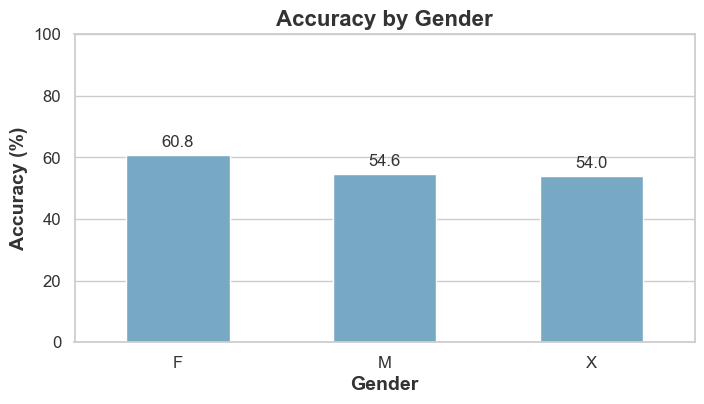

In [106]:
# Plot for Accuracy by Gender
styled_barplot(total_gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

# Visualisations

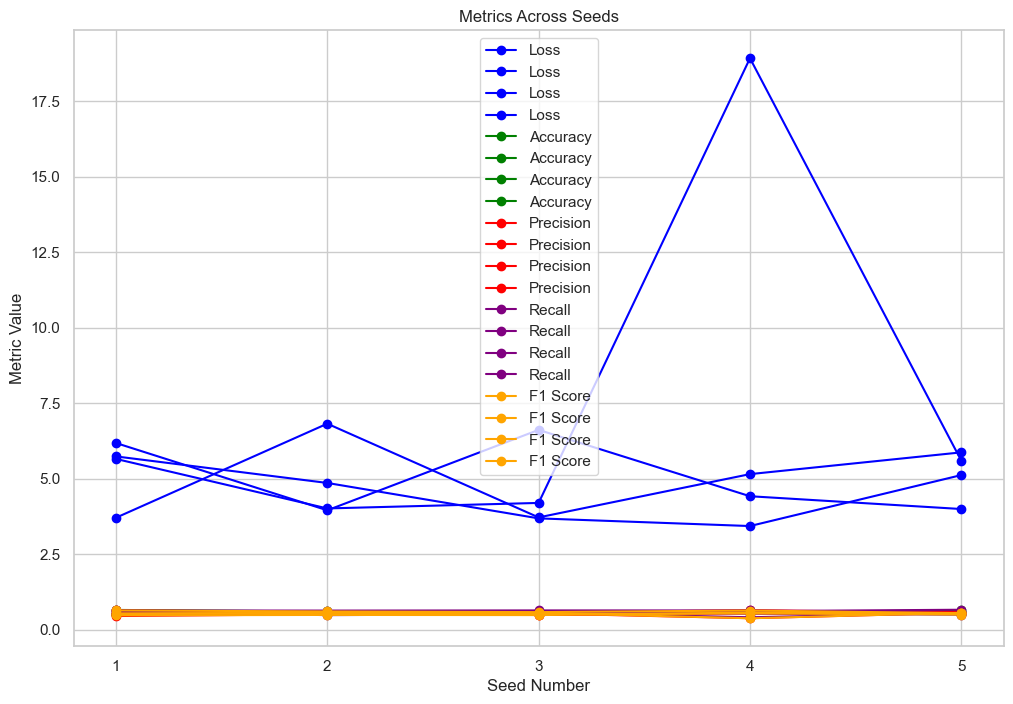

In [107]:
# Plotting all metrics
metrics_across_seeds = plot_all_metrics(all_losses, all_accuracies, all_precisions, all_recalls, all_f1, "Seeds", "Seed Number")

## Display the seed folds results together

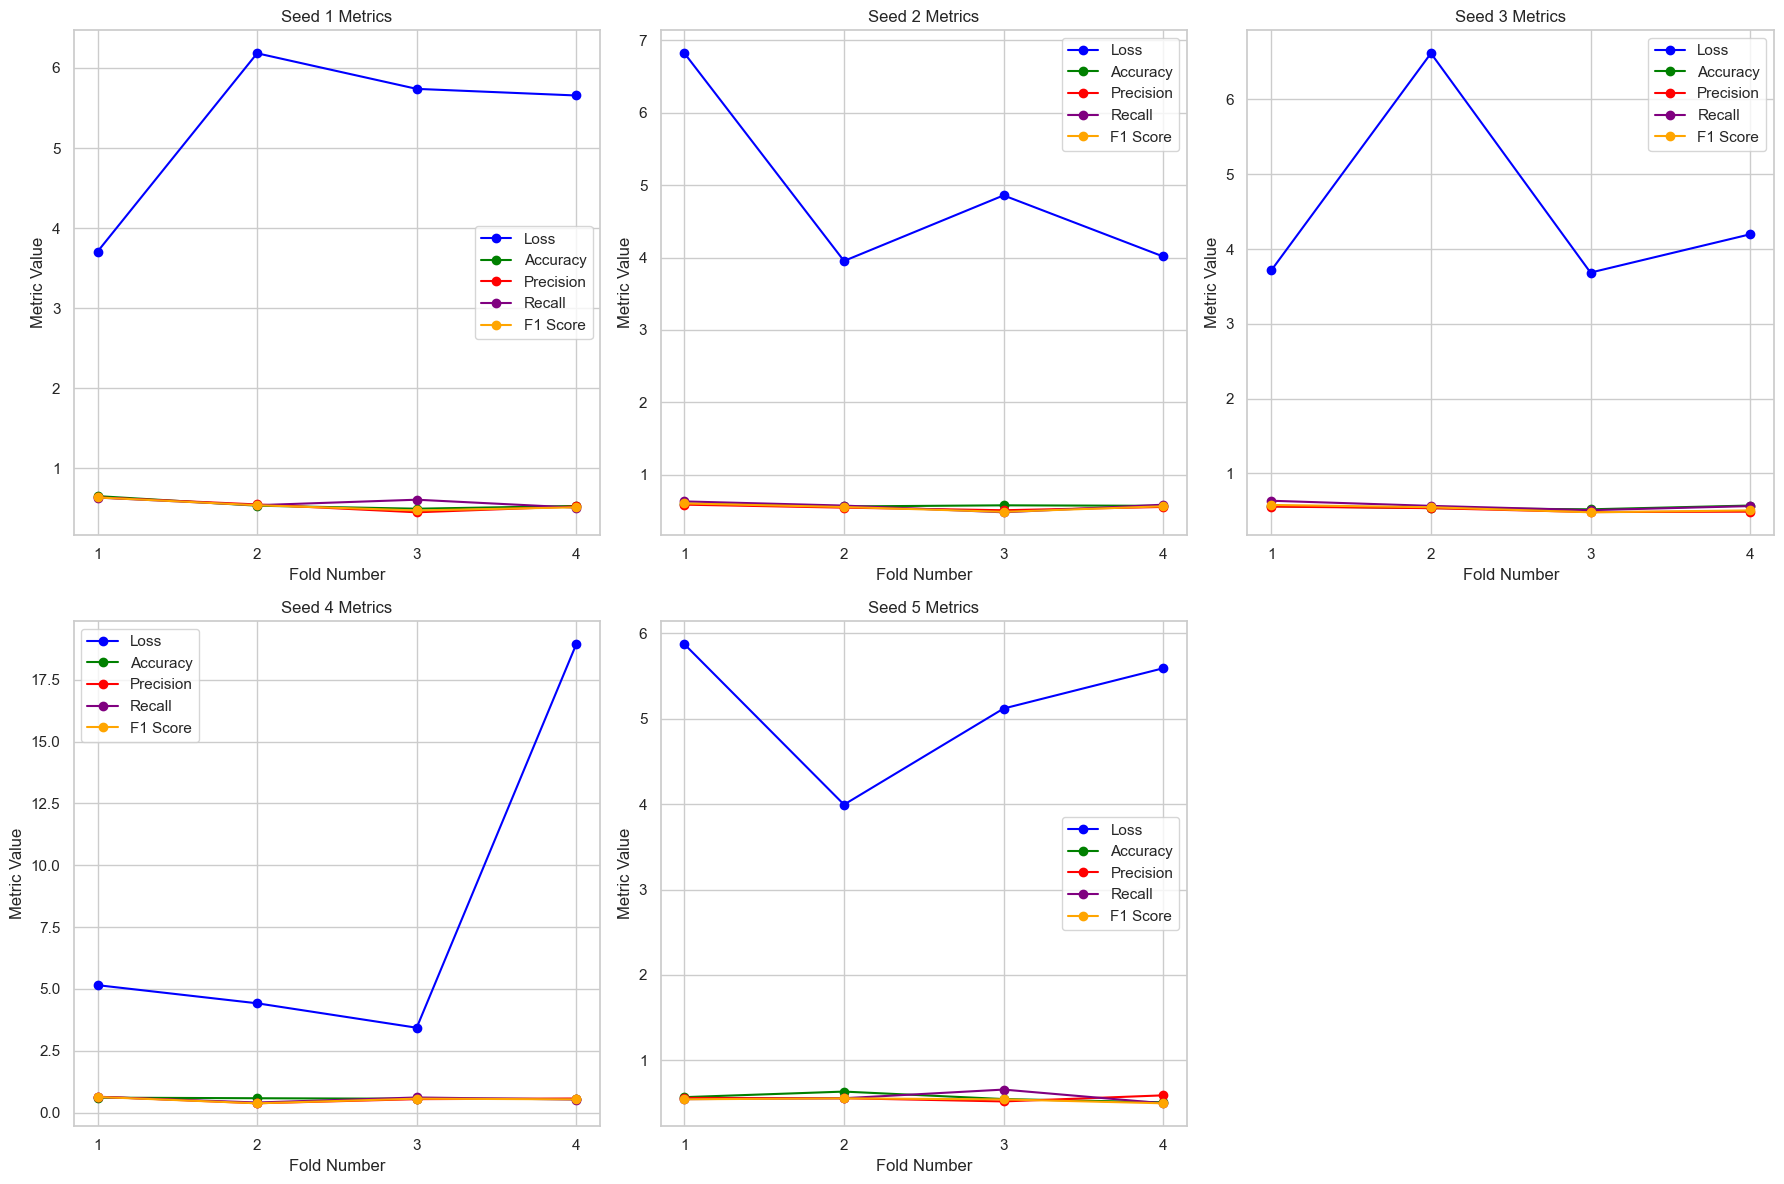

In [108]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))  

# Flatten the axes array for easier indexing
axes = axes.flatten()

def plot_metrics_on_axes(ax, losses, accuracies, precisions, recalls, f1, title):
    ax.plot(range(1, len(losses)+1), losses, marker='o', color='blue', label='Loss')
    ax.plot(range(1, len(accuracies)+1), accuracies, marker='o', color='green', label='Accuracy')
    ax.plot(range(1, len(precisions)+1), precisions, marker='o', color='red', label='Precision')
    ax.plot(range(1, len(recalls)+1), recalls, marker='o', color='purple', label='Recall')
    ax.plot(range(1, len(f1)+1), f1, marker='o', color='orange', label='F1 Score')
    ax.set_xticks([1, 2, 3, 4])  # Set x-axis ticks to full integers
    ax.set_title(title)
    ax.set_xlabel('Fold Number')
    ax.set_ylabel('Metric Value')
    ax.legend()
    ax.grid(True)

# Plot onto each axes object
plot_metrics_on_axes(axes[0], *seed_1_folds_values, "Seed 1 Metrics")
plot_metrics_on_axes(axes[1], *seed_2_folds_values, "Seed 2 Metrics")
plot_metrics_on_axes(axes[2], *seed_3_folds_values, "Seed 3 Metrics")
plot_metrics_on_axes(axes[3], *seed_4_folds_values, "Seed 4 Metrics")
plot_metrics_on_axes(axes[4], *seed_5_folds_values, "Seed 5 Metrics")

# Hide the unused subplot 
for ax in axes[5:]:
    ax.set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

# Statistics

In [109]:
# Calculate the standard deviation for each metric
std_loss = np.std(all_losses)
std_accuracy = np.std(all_accuracies)
std_precision = np.std(all_precisions)
std_recall = np.std(all_recalls)
std_f1 = np.std(all_f1)

print("Standard Deviations:")
print(f"Loss: {std_loss}")
print(f"Accuracy: {std_accuracy}")
print(f"Precision: {std_precision}")
print(f"Recall: {std_recall}")
print(f"F1 Score: {std_f1}")

Standard Deviations:
Loss: 3.2275065745541354
Accuracy: 0.03830145332287016
Precision: 0.05871714716917157
Recall: 0.061968216529191364
F1 Score: 0.057288573873462686


In [110]:
# Calculate the interquartile range for each metric
iqr_loss = np.percentile(all_losses, 75) - np.percentile(all_losses, 25)
iqr_accuracy = np.percentile(all_accuracies, 75) - np.percentile(all_accuracies, 25)
iqr_precision = np.percentile(all_precisions, 75) - np.percentile(all_precisions, 25)
iqr_recall = np.percentile(all_recalls, 75) - np.percentile(all_recalls, 25)
iqr_f1 = np.percentile(all_f1, 75) - np.percentile(all_f1, 25)

print("Interquartile Ranges:")
print(f"Loss: {iqr_loss}")
print(f"Accuracy: {iqr_accuracy}")
print(f"Precision: {iqr_precision}")
print(f"Recall: {iqr_recall}")
print(f"F1 Score: {iqr_f1}")


Interquartile Ranges:
Loss: 1.7875310182571411
Accuracy: 0.04107515513896942
Precision: 0.04641071697307131
Recall: 0.09213630973273401
F1 Score: 0.059149190085846515


### Variation

In [111]:
# Calculate the variation for each metric
var_loss = np.var(all_losses)
var_accuracy = np.var(all_accuracies)
var_precision = np.var(all_precisions)
var_recall = np.var(all_recalls)
var_f1 = np.var(all_f1)

print("Variations:")
print(f"Loss: {var_loss}")
print(f"Accuracy: {var_accuracy}")
print(f"Precision: {var_precision}")
print(f"Recall: {var_recall}")
print(f"F1 Score: {var_f1}")

Variations:
Loss: 10.41679868879017
Accuracy: 0.0014670013266440019
Precision: 0.003447703371686153
Recall: 0.003840059859808746
F1 Score: 0.003281980696455191


### Levene tests for variation significance between seeds

#### Levene across seeds for LOSS

In [112]:
# Levene across seeds for LOSS
stat_val, p_val = levene(seed_1_folds_values[0], seed_2_folds_values[0], seed_3_folds_values[0], seed_4_folds_values[0], seed_5_folds_values[0])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.90, P-value: 0.488


#### Levene across seeds for ACCURACY

In [113]:
# Levene across seeds for ACCURACY
stat_val, p_val = levene(seed_1_folds_values[1], seed_2_folds_values[1], seed_3_folds_values[1], seed_4_folds_values[1], seed_5_folds_values[1])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.69, P-value: 0.613


#### Levene across seeds for PRECISION

In [114]:
# Levene across seeds for PRECISION
stat_val, p_val = levene(seed_1_folds_values[2], seed_2_folds_values[2], seed_3_folds_values[2], seed_4_folds_values[2], seed_5_folds_values[2])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 1.16, P-value: 0.367


#### Levene across seeds for RECALL

In [115]:
# Levene across seeds for RECALL
stat_val, p_val = levene(seed_1_folds_values[3], seed_2_folds_values[3], seed_3_folds_values[3], seed_4_folds_values[3], seed_5_folds_values[3])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.65, P-value: 0.637


#### Levene across seeds for F1

In [116]:
# Levene across seeds for F1
stat_val, p_val = levene(seed_1_folds_values[4], seed_2_folds_values[4], seed_3_folds_values[4], seed_4_folds_values[4], seed_5_folds_values[4])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.90, P-value: 0.488


## Print out measurements for future further analysis (without rerunning notebook)

In [117]:
seed_1_folds_values

[[3.70603346824646, 6.183104515075684, 5.738619804382324, 5.656033039093018],
 [0.6516854166984558,
  0.5321100950241089,
  0.4942965805530548,
  0.5288461446762085],
 [0.635978835978836,
  0.5477104924473345,
  0.4495572946692801,
  0.522716049382716],
 [0.6336120401337793,
  0.5384936381445479,
  0.6068140644064036,
  0.5077403245942572],
 [0.6345667722999143,
  0.5379969663428033,
  0.47267809945294736,
  0.5121051534401984]]

In [118]:
seed_2_folds_values

[[6.822924613952637, 3.952930450439453, 4.859235763549805, 4.014749050140381],
 [0.6000000238418579,
  0.5604395866394043,
  0.5759717226028442,
  0.5688889026641846],
 [0.5852152023085897,
  0.5438177903931328,
  0.5078982984090271,
  0.5534354237562794],
 [0.6298319327731093,
  0.5723032886967313,
  0.4795407185129616,
  0.5845864661654135],
 [0.6019473081328751,
  0.5525823112568461,
  0.48604612576738004,
  0.56294726177145]]

In [119]:
seed_3_folds_values

[[3.7172791957855225,
  6.617351055145264,
  3.6855623722076416,
  4.197205066680908],
 [0.5631067752838135,
  0.5373831987380981,
  0.5209125280380249,
  0.5714285969734192],
 [0.5571584363495304,
  0.5363795518207283,
  0.4840795262910977,
  0.48926084083168114],
 [0.6353121478476448,
  0.5669601173802855,
  0.509503877032869,
  0.563907632328685],
 [0.5793851831003534,
  0.5485694108783311,
  0.4809761796585968,
  0.5062686576986323]]

In [120]:
seed_4_folds_values

[[5.151669502258301, 4.418916702270508, 3.431180715560913, 18.93152618408203],
 [0.603960394859314,
  0.5806451439857483,
  0.559183657169342,
  0.5480769276618958],
 [0.6439451201355962,
  0.3769953650550666,
  0.5434071825540655,
  0.5699438934733052],
 [0.6343114543114544,
  0.4081384015594542,
  0.6111506243085191,
  0.5284115632449539],
 [0.6318605845606239,
  0.3760256614307227,
  0.5638483085541909,
  0.535872480179298]]

In [121]:
all_best_training_acc

[0.998734176158905,
 1.0,
 0.9957447052001953,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9986541271209717,
 1.0,
 1.0,
 0.99858158826828,
 1.0,
 0.997389018535614,
 1.0,
 1.0,
 1.0,
 0.9986945390701294,
 1.0,
 1.0,
 1.0]

In [122]:
total_training_acc

[[0.5721518993377686,
  0.7696202397346497,
  0.850632905960083,
  0.8772152066230774,
  0.9113923907279968,
  0.905063271522522,
  0.9151898622512817,
  0.9177215099334717,
  0.9430379867553711,
  0.9518987536430359,
  0.9607595205307007,
  0.949367105960846,
  0.9683544039726257,
  0.948101282119751,
  0.9721518754959106,
  0.9759493470191956,
  0.9797468185424805,
  0.9797468185424805,
  0.9822784662246704,
  0.9822784662246704,
  0.9822784662246704,
  0.9746835231781006,
  0.9797468185424805,
  0.9873417615890503,
  0.9898734092712402,
  0.9886075854301453,
  0.9822784662246704,
  0.9949367046356201,
  0.9886075854301453,
  0.9911392331123352,
  0.9924050569534302,
  0.9898734092712402,
  0.9911392331123352,
  0.9822784662246704,
  0.9860759377479553,
  0.9898734092712402,
  0.9911392331123352,
  0.9886075854301453,
  0.9848101139068604,
  0.9936708807945251,
  0.9936708807945251,
  0.9974683523178101,
  0.9873417615890503,
  0.9936708807945251,
  0.998734176158905,
  0.99113923311

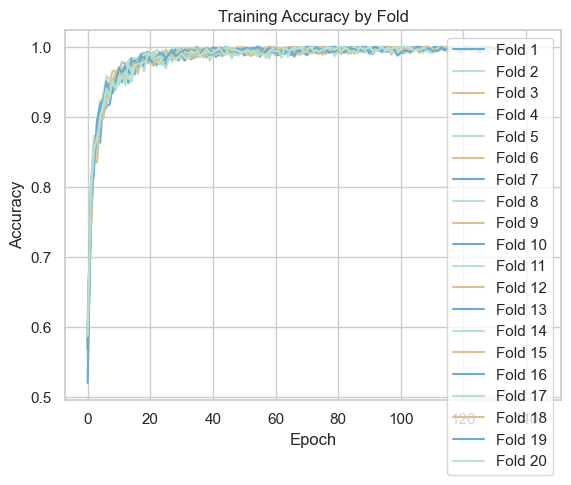

In [123]:
# Plot accuracy histories for all folds
for i, fold_accuracy in enumerate(total_training_acc):
    plt.plot(fold_accuracy, label=f'Fold {i+1}')

plt.title('Training Accuracy by Fold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.savefig("YAMNet_categorical_training_accuracy")

plt.legend()
plt.show()

In [124]:
# running time including analysis
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 200.9108371734619 seconds
